## Jeffrey Elkner

### Problem: Point Pattern Descriptors

The tracking data for Hurricane Bill (2009) is given in the attached package, suitable for ArcGIS. One folder contains the best track data via SHIPS database (SHIPS_2009Bill) and the other is a track forecasting data from NHC (National Hurricane Center) for Hurricane Bill at August 17 at 1500 (2009BillForecasting17_1500) for forecasting tracks in 12 hours interval for 3 days and 24 hour interval beyond that for up to 5 days.  Using the SHIPS data, please

> a. Calculate the Standard Distance and output the SD value (3 points)

The standard distance is 16.16 from mean center of (-53.87, 23.10).


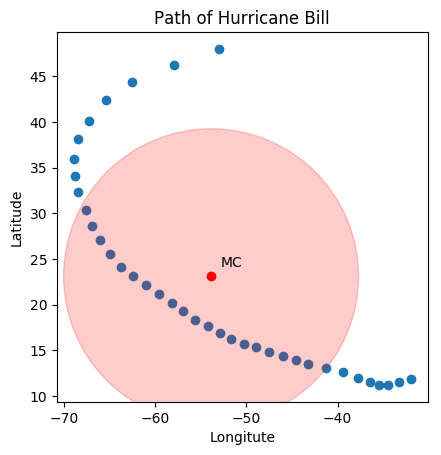

In [1]:
# SOLUTION
# http://webspace.ship.edu/pgmarr/Geo441/Examples/Standard%20Distance.pdf
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
from matplotlib.patches import Circle
import numpy as np
import thinkstats2 as ts
import shapefile
from ggs560.ggs560_tools import mean_center, standard_distance

def shape2dataframe(path2shape):
    sf = shapefile.Reader(path2shape)

    #grab the shapefile's field names (omit the first psuedo field)
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]

    #write the records into a dataframe
    shpdf = pd.DataFrame(columns=fields, data=records)

    #add the coordinate data to a column called "coords"
    shpdf = shpdf.assign(coords=shps)
    
    return shpdf

df = shape2dataframe('Data/SHIPS_2009Bill/SHIPS_2009Bill')

def calc_and_display_standard_distance(df, title=''):
    xs = [point[0][0] for point in df.coords]
    ys = [point[0][1] for point in df.coords]
    cx, cy = mean_center(list(zip(xs, ys)))
    sd = standard_distance(xs, ys)

    # Print out the mean center and standard distance
    s = ("The standard distance is {:0.2f} from mean center "
         "of ({:0.2f}, {:0.2f})."
        )
    print(s.format(sd, cx, cy))

    plt.scatter(xs, ys)
    plt.plot([cx], [cy], 'ro')
    plt.gca().annotate('MC', xy=(cx, cy), xytext=(cx + 1, cy + 1))
    plt.gca().set_aspect('equal')
    circle = plt.Circle((cx, cy), sd, color='red', alpha=0.2)
    plt.gca().add_artist(circle)
    plt.title(title)
    plt.xlabel('Longitute')
    plt.ylabel('Latitude')
    plt.show()
    
calc_and_display_standard_distance(df, 'Path of Hurricane Bill')

> b. Calculate the deviational ellipse (Directional Distribution) and output the rotation angle, and the deviations along the major axis and minor axis. (3 points)

In [2]:
# SOLUTION
# http://tinyurl.com/standarddeviationalellipse
# http://tinyurl.com/standarddeviationalellipse2
# http://tinyurl.com/standarddeviationalellipse3
# http://blog.mmast.net/conics-matplotlib

def directional_distribution_analysis(df):
    xs = [point[0][0] for point in df.coords]
    ys = [point[0][1] for point in df.coords]
    cx, cy = mean_center(list(zip(xs, ys)))

    # Move points to center at mean center
    xps = [x_i - cx for x_i in xs]
    yps = [y_i - cy for y_i in ys]

    # Calulate A, B, and C
    A = sum([x_i**2 for x_i in xps]) - sum([y_i**2 for y_i in yps])

    # compute the sum of products of moved points
    sop = sum([xps[i] * yps[i] for i in range(len(xps))])

    B = (A**2 + 4 * sop**2)**0.5
    C = 2 * sop

    # Calculate the angle of rotation
    tan_theta = (A + B) / C
    theta = np.arctan(tan_theta)
    s = "The angle of rotation is {:0.2f} radians or {:0.2f} degrees."
    print(s.format(theta, np.degrees([theta])[0]))

    # Calculate deviations along major and minor axes
    # Precalculate some values
    n = len(xps)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    # Calculate x-axis deviation
    numeratorSigmaX =  sum([(xps[i] * cos_theta -
                             yps[i] * sin_theta)**2 for i in range(n)])
    SigmaX = 2**0.5 * (numeratorSigmaX / n)**0.5

    # Calculate y-axis deviation
    numeratorSigmaY =  sum([(xps[i] * sin_theta +
                             yps[i] * cos_theta)**2 for i in range(n)])
    SigmaY = 2**0.5 * (numeratorSigmaY / n)**0.5

    s = "The axes deviations are x-axis: {:0.2f} and y-axis: {:0.2f}."
    print(s.format(SigmaX, SigmaY))
    
    return xs, ys, cx, cy, xps, yps, SigmaX, SigmaY 


xs, ys, cx, cy, xps, yps, SigmaX, SigmaY = directional_distribution_analysis(df)

The angle of rotation is -0.82 radians or -46.90 degrees.
The axes deviations are x-axis: 8.12 and y-axis: 21.37.


> c. Show that the total circular variance is conserved before and after the rotation or the conservation relationship between the standard distance and the semi-major and semi-minor axes of the deviational ellipse. (3 points)

*Solution*: From slide 17 in our notes, we will verifying that $2(\sigma_x^2 + \sigma_y^2) = 2SD^2$.

In [3]:
var1 = SigmaX**2 + SigmaY**2
xssq = sum([(x - cx)**2 for x in xs])
yssq = sum([(y - cy)**2 for y in ys])
var2 = 2 * (xssq + yssq) / len(xs)

print('{:0.2f} equals {:0.2f}?'.format(var1, var2))

522.56 equals 522.56?


The results are equal and we have shown that circular variance is conserved.

> d. Use the forecasting data to repeat the Directional Distribution analysis. (1 point)

The standard distance is 9.28 from mean center of (-55.12, 19.74).


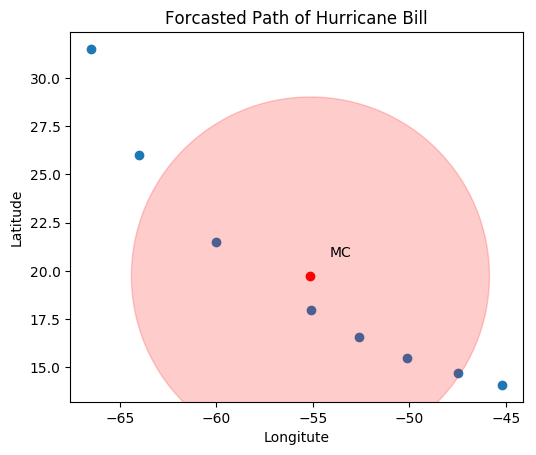

The angle of rotation is -0.90 radians or -51.63 degrees.
The axes deviations are x-axis: 1.87 and y-axis: 12.99.


In [4]:
# SOLUTION
df2 = shape2dataframe('Data/BillForcast/2009Bill_Forecasting17_1500')
calc_and_display_standard_distance(df2, 'Forcasted Path of Hurricane Bill')
results = directional_distribution_analysis(df2)

> e. (Optional/open-end) Please compare the results of the directional distribution from the SHIPS data and from the forecasting data and discuss the possibility for using the forecasting data to cluster tracks of tropical cyclones. (xx points)

*SOLUTION*: The mean center and angle of rotation of both the actual path in the SHIPS data and that of the forcast appear fairly close, while the minor axis of the elipse of the actual path of Hurricane Bill is larger than that of the forcaste.  This is a result of the larger curvature of the actual path the hurricane followed.

#### Notes for additional information:
1. The SHIPS data files can be found at ftp://rammftp.cira.colostate.edu/demaria/SHIPS/. One of the data files for the period 1989-2009 hurricane season can be downloaded at ftp://rammftp.cira.colostate.edu/demaria/SHIPS/2010/lsdiaga_1982_2009_rean_biascorr_sat.dat, and the corresponding document file for this data file is also available at ftp://rammftp.cira.colostate.edu/demaria/SHIPS/2009/SHIPS_predictor_file_2009.doc. The original data are in ASCII but the data are hard to handle.

2. The forecasting data can be found at http://www.nhc.noaa.gov/data/. More information including the metadata information can also be found in the same site. 